# TASK 4: Classification 1 - 5 Nodules

## Downloading nodule images and associating them to their label

In [1]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "/kaggle/input/dataset-csv/dataset_lung.xlsx"
data = pd.read_excel(csv_path)

data.head()

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4


In [2]:
def load_nrrd(file_path):
    """Load an NRRD file using SimpleITK."""

    train_loc = '/kaggle/input/test-dataset/Train'
    
    file_path = os.path.join(train_loc, file_path)
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
    return array

In [3]:
data_loaded = False
if not data_loaded:
   # images = data['Full_slice']
   # images = images.apply(load_nrrd)

    nodules = data['Nodule']
    nodules = nodules.apply(load_nrrd)

    labels = data['TumorClass']

    #analyzing nodule images shape
    print(nodules[0].shape)
    print(nodules[1].shape)

    np.savez("new_dataset", labels=labels, nodules=nodules)
    
else:
    path = ''
    data = np.load(path)
    labels = data['labels']
    nodules = data['nodules']

(84, 92)
(90, 85)


**We observed that the nodule images vary in size**

In [ ]:
def visualize_image(image, title="Image"):
    """Visualize a 2D nodule image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize nodule
visualize_image(nodules[0], title="Nodule")


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
label_counts = Counter(labels)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), alpha=0.7)
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**The dataset is highly unbalanced**

# **Exploratory Data Analysis Nodules Images**

## RESHAPE OF NODULE IMAGES --> 224x224

**We resized all images to 224 × 224 to ensure uniformity in the dataset and match the input size required by the EfficientNetB0 model.**

In [4]:
import cv2
num_images = len(nodules)

new_shape = (224, 224) #resnet, efficientnet
#new_shape = (299, 299) #inception

new_nodules = np.zeros((num_images, new_shape[1], new_shape[0]))
new_labels = np.zeros(num_images) - 1

print(new_nodules.shape)
for i, n in enumerate(nodules.copy()):
    img = cv2.resize(n, new_shape, interpolation=cv2.INTER_CUBIC)#.reshape(new_shape[0], new_shape[1], 1)    
    new_nodules[i] = img
    new_labels[i] = labels[i] #per tenere la variabile new_labels che avevamo aggiunto

new_labels = new_labels.astype(int)
new_nodules.shape

(2363, 224, 224)


(2363, 224, 224)

**We analyzed the pixel intensity values of the images and found that they are in int16 format, meaning they are represented in Hounsfield Units (HU). HU is a standardized scale used in CT imaging to quantify tissue density, where different materials (e.g., air, soft tissue, bone) have distinct intensity ranges. Given this, the images will be normalized to a 0-255 range to ensure compatibility with the deep learning model.**

In [ ]:
# Calcolo della media
media = np.mean(nodules[0])

# Calcolo del valore massimo
valore_max = np.max(nodules[0])

# Calcolo del valore minimo
valore_min = np.min(nodules[0])

# Output dei risultati
print(f"Media: {media}")
print(f"Valore massimo: {valore_max}")
print(f"Valore minimo: {valore_min}")
print("Tipo",nodules[0].dtype)

## SPLIT INTO TRAIN, VALIDATION E TEST

In [5]:
from sklearn.model_selection import train_test_split
y = new_labels
X = new_nodules

# Divisione iniziale in train, validation e test set
X_d, X_test, y_d, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_d, y_d, test_size=0.1, stratify=y_d, random_state=42)

## NORMALIZATION BETWEEN 0 AND 255 (UINT8) 

In [6]:
# Calcolo del minimo e massimo da X_train
X_train_min = np.min(X_train)
X_train_max = np.max(X_train)

# Normalizzazione di X_train tra 0 e 255 e conversione a uint8
X_train_scaled = ((X_train - X_train_min) / (X_train_max - X_train_min) * 255).astype(np.uint8)

# Normalizzazione di X_valid e X_test usando il range di X_train e conversione a uint8
X_valid_scaled = ((X_valid - X_train_min) / (X_train_max - X_train_min) * 255).astype(np.uint8)
X_test_scaled = ((X_test - X_train_min) / (X_train_max - X_train_min) * 255).astype(np.uint8)

# Clipping dei valori di validazione e test tra 0 e 255 
X_valid_scaled = np.clip(X_valid_scaled, 0, 255)
X_test_scaled = np.clip(X_test_scaled, 0, 255)


print(f"Minimo di X_train_normalized: {np.min(X_train_scaled)}")
print(f"Massimo di X_train_normalized: {np.max(X_train_scaled)}")
print(f"Minimo di X_valid_scaled: {np.min(X_valid_scaled)}")
print(f"Massimo di X_valid_scaled: {np.max(X_valid_scaled)}")
print(f"Minimo di X_test_scaled: {np.min(X_test_scaled)}")
print(f"Massimo di X_test_scaled: {np.max(X_test_scaled)}")



Minimo di X_train_normalized: 0
Massimo di X_train_normalized: 255
Minimo di X_valid_scaled: 89
Massimo di X_valid_scaled: 219
Minimo di X_test_scaled: 0
Massimo di X_test_scaled: 255


In [7]:
X_train = X_train_scaled
X_valid = X_valid_scaled
X_test = X_test_scaled

## Testing the Augmentation Strategy for Dataset Balancing

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Configura il generatore per la data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,           # Rotazione ±30°
        width_shift_range=0.1,       # Traslazione orizzontale ±10%
        height_shift_range=0.1,      # Traslazione verticale ±10%
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'          # Riempimento dei bordi
    )

# Seleziona 10 immagini casuali dal training set
num_images = 20
random_indices = np.random.choice(len(X_train), num_images, replace=False)
selected_images = X_train[random_indices]
selected_labels = y_train[random_indices]

# Assicurati che le immagini abbiano un asse di canale (se necessario)
selected_images = selected_images[..., np.newaxis] if selected_images.ndim == 3 else selected_images

# Crea una figura per plottare le immagini
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

for i, ax_pair in enumerate(axes):
    original_ax, augmented_ax = ax_pair

    # Immagine originale
    original_image = selected_images[i]
    original_ax.imshow(original_image.squeeze(), cmap='gray')
    original_ax.set_title(f"Original (Label: {selected_labels[i]})")
    original_ax.axis('off')

    # Applica augmentation
    augmented_image = datagen.random_transform(original_image)
    augmented_ax.imshow(augmented_image.squeeze(), cmap='gray')
    augmented_ax.set_title(f"Augmented (Label: {selected_labels[i]})")
    augmented_ax.axis('off')

# Mostra le immagini
plt.tight_layout()
plt.show()


## CLASS BALANCING METHOD : SMOTE + AUGMENTATION

In [ ]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Aggiungi un asse per i canali
if X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]  # Aggiungi asse dei canali

# Function to balance classes with SMOTE
def balance_with_smote(X, y, additional_samples=250):
    """
    Balances the dataset using SMOTE by adding the specified number of samples per class.
    
    Args:
        X: Input data (e.g., images).
        y: Corresponding labels.
        additional_samples: Number of additional samples to generate per class.
    
    Returns:
        X_resampled: Resampled input data.
        y_resampled: Resampled labels.
    """
    print("\n--- Inizio SMOTE ---")
    # Flatten the images for SMOTE
    X_flat = X.reshape(X.shape[0], -1)
    
    # Count the samples for each class
    class_counts = {cls: (y == cls).sum() for cls in np.unique(y)}
    print("Distribuzione iniziale delle classi:", class_counts)
    
    # Define the sampling strategy: add `additional_samples` for each class
    sampling_strategy = {cls: class_counts[cls] + additional_samples for cls in np.unique(y)}
    
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)
    
    # Reshape the resampled images back to their original dimensions
    X_resampled = X_resampled_flat.reshape(-1, X.shape[1], X.shape[2], X.shape[3])
    
    # Print the updated class distribution
    updated_counts = {cls: (y_resampled == cls).sum() for cls in np.unique(y_resampled)}
    print("Distribuzione dopo SMOTE:", updated_counts)
    print("--- Fine SMOTE ---\n")
    
    return X_resampled, y_resampled


X_smote, y_smote = balance_with_smote(X_train, y_train)


def augment_classes(X, y, target_class_count):
    """
    Augments all classes to the number of samples in the most represented class.
    For the majority class, replaces 1/3 of the samples with augmented versions.

    Args:
        X: Input data (e.g., images).
        y: Corresponding labels.
        target_class_count: Number of samples to reach for all classes.

    Returns:
        X_balanced: Augmented dataset.
        y_balanced: Corresponding labels.
    """
    print("\n--- Inizio Data Augmentation ---")
    datagen = ImageDataGenerator(
        rotation_range=30,           # Rotazione ±30°
        width_shift_range=0.1,       # Traslazione orizzontale ±10%
        height_shift_range=0.1,      # Traslazione verticale ±10%
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'          # Riempimento dei bordi
    )
    
    augmented_images = []
    augmented_labels = []
  
    # Calcola la classe più rappresentata
    class_counts = {cls: (y == cls).sum() for cls in np.unique(y)}
    print("Distribuzione prima di Data Augmentation:", class_counts)
    
    for cls, count in class_counts.items():
        class_images = X[y == cls]
        if count < target_class_count:  # Augment underrepresented classes
            print(f"Lavorando sulla classe {cls} con {count} campioni...")
            
            num_to_generate = target_class_count - count
            generated_count = 0
            
            while generated_count < num_to_generate:
                for img in class_images:
                    augmented_images.append(datagen.random_transform(img))
                    augmented_labels.append(cls)
                    generated_count += 1
                    if generated_count >= num_to_generate:
                        break
            
            print(f"Generati {generated_count} nuovi campioni per la classe {cls}")
        
        
        else:  # Replace 1/3 of majority class with augmented samples
            print(f"Modificando la classe {cls} (maggiore) con {count} campioni...")
            num_to_replace = count // 3
            selected_indices = np.random.choice(range(count), size=num_to_replace, replace=False)
            
            augmented_images_majority = []
            for idx in selected_indices:
                augmented_images_majority.append(datagen.random_transform(class_images[idx]))
                
            # Replace the selected samples in the majority class
            X[y == cls][selected_indices] = np.array(augmented_images_majority)
            
    
    # Combina le immagini augmentate con il dataset originale
    X_balanced = np.concatenate([X, np.array(augmented_images)], axis=0)
    y_balanced = np.concatenate([y, np.array(augmented_labels)], axis=0)
    
    # Calcola la nuova distribuzione
    final_distribution = {cls: (y_balanced == cls).sum() for cls in np.unique(y_balanced)}
    print("Distribuzione finale dopo Data Augmentation:", final_distribution)
    print("--- Fine Data Augmentation ---\n")
    
    return X_balanced, y_balanced

# Example Usage:
# Assuming X_smote and y_smote are the datasets after SMOTE
max_class_count = max((y_smote == cls).sum() for cls in np.unique(y_smote))
X_final, y_final = augment_classes(X_smote, y_smote, target_class_count=max_class_count)


In [ ]:
X_train = X_final
y_train = y_final

In [ ]:
print(f"Shape di X_valid: {X_valid.shape}, Shape di y_valid: {y_valid.shape}")
print(f"Shape di X_train: {X_train.shape}, Shape di y_train: {y_train.shape}")
print(f"Shape di X_test: {X_test.shape}, Shape di y_test: {y_test.shape}")

**We brought all classes to 1036 samples each**

In [ ]:
classes_names_bin, counts_bin = np.unique(y_train, return_counts=True)

print(classes_names_bin, counts_bin)

#for plotting we can use plt.bar function for example
plt.bar(x=classes_names_bin,height=counts_bin, facecolor ='#85c1e9')
plt.title("Classes Occurrence after balancing", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

## PLOT IMAGES

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Numero di immagini da plottare per ciascuna label
num_images_per_label = 10

# Identifica le label uniche
unique_labels = np.unique(y_train)

# Prepara una lista per salvare le immagini selezionate
selected_indices = []

# Per ogni label, seleziona 5 indici casuali
for label in unique_labels:
    label_indices = np.where(y_train == label)[0]
    selected_indices.extend(np.random.choice(label_indices, num_images_per_label, replace=False))

# Crea la figura con un layout 5x5
fig, axes = plt.subplots(5, 10, figsize=(15, 15))

# Ciclo sulle immagini selezionate e sulle assi per plottarle
for i, ax in enumerate(axes.flat):
    idx = selected_indices[i]
    ax.imshow(X_train[idx], cmap='gray')  # Usa cmap='gray' per immagini in scala di grigi
    ax.set_title(f"Label: {y_train[idx]}")  # Etichetta dell'immagine
    ax.axis('off')  # Nasconde gli assi

# Mostra il grafico
plt.tight_layout()
plt.show()




**We plotted a series of images from the training set after dataset balancing. The samples generated by SMOTE are quite noticeable; however, they still contribute to dataset variability and help improve the model's performance.**

##  Converting grayscale images to RGB

In [8]:
import numpy as np

# Rimuovi il canale aggiunto per SMOTE (se esiste)
if X_train.shape[-1] == 1:  # Controlla se c'è un canale aggiunto
    X_train = X_train.squeeze(-1)  # Rimuovi l'asse del canale

if X_valid.shape[-1] == 1:  # Controlla se c'è un canale aggiunto
    X_valid = X_valid.squeeze(-1)  # Rimuovi l'asse del canale

if X_test.shape[-1] == 1:  # Controlla se c'è un canale aggiunto
    X_test = X_test.squeeze(-1)  # Rimuovi l'asse del canale

# Ripeti il canale singolo per creare immagini a 3 canali (RGB)
X_train_3channel = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_valid_3channel = np.repeat(X_valid[..., np.newaxis], 3, axis=-1)
X_test_3channel = np.repeat(X_test[..., np.newaxis], 3, axis=-1)



# Stampa le nuove shape per verifica
print("Nuova shape di X_train_3channel:", X_train_3channel.shape)
print("Nuova shape di X_valid_3channel:", X_valid_3channel.shape)
print("Nuova shape di X_test_3channel:", X_test_3channel.shape)




Nuova shape di X_train_3channel: (1701, 224, 224, 3)
Nuova shape di X_valid_3channel: (189, 224, 224, 3)
Nuova shape di X_test_3channel: (473, 224, 224, 3)


In [9]:
X_train = X_train_3channel
X_valid = X_valid_3channel
X_test = X_test_3channel

# bringing the labels from 0 to 4
y_train = y_train-1
y_valid = y_valid-1
y_test = y_test-1

## Image Datagenerator definition

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,Callback, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations

# BEST DATAGENERATOR among the ones we tried
train_datagen = ImageDataGenerator(
    rotation_range=360, 
    width_shift_range=0.2,  # Increase shift range
    height_shift_range=0.2,
    shear_range=0.2,  # Increase transformation intensity
    zoom_range=(0.7, 1.3),  # More zoom variability
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.6, 1.4),  # Stronger brightness augmentation
    fill_mode='nearest',
)
                                    

train_datagen.fit(X_train)
batch_size = 64

# Seed fisso per garantire riproducibilità
seed = 42

# Generate batches of augmented data from numpy arrays
train_generator = train_datagen.flow(
    x=X_train, y=y_train,
    batch_size=batch_size,
    shuffle = True,
    seed=seed  
)


## Model download and definition

In [ ]:
#EFFICIENTNETB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Carica EfficientNetB0 pre-addestrato su ImageNet
efficientnet_b0 = EfficientNetB0(
    weights='imagenet',        # Pesi pre-addestrati su ImageNet
    include_top=False,         # Escludi il classificatore Fully Connected (FC)
    input_shape=(224, 224, 3), # Dimensione di input richiesta da EfficientNetB0
    pooling='avg'              # Usa Global Average Pooling al posto del classificatore
)

#check size consistency and labels value
print("Shape X_train:", X_train.shape)
print("Shape Y_train:", y_train.shape)

print("Shape X_val:", X_valid.shape)
print("Shape Y_val:", y_valid.shape)

# Stampa i valori unici di y_train e y_valid
print("Valori unici in y_train:", np.unique(y_train))
print("Valori unici in y_valid:", np.unique(y_valid))


In [ ]:
import tensorflow.keras as tfk
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers as tfkl


# Freeze the entire model
efficientnet_b0.trainable = False

# Unfreeze the last 20 layers 
for layer in efficientnet_b0.layers[-20:]:
    layer.trainable = True

from tensorflow.keras.layers import Rescaling
import tensorflow as tf
from tensorflow.keras import layers as tfkl


from tensorflow.keras.applications.efficientnet import preprocess_input


inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')

# Connect efficientnet_b0 to the input
x = efficientnet_b0(inputs)
x = tfkl.Dropout(0.2, name='dropout0')(x)
x = tfkl.BatchNormalization(name='batchnorm0')(x)


x = tfkl.Dense(64, activation='relu', name='dense3')(x)
x = tfkl.Dropout(0.2, name='dropout3')(x)


# Output Layer con softmax per 5 classi
outputs = tfkl.Dense(5, activation='softmax', name='dense4')(x)


# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Definizione dell'ottimizzatore Adam con learning rate 
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compila il modello con Adam
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=adam_optimizer,
    metrics=['accuracy']
)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## TRAINING THE MODEL

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback per ridurre il learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',          # Monitora la perdita di validazione
    factor=0.5,                  # Riduce il learning rate di un fattore di 0.5
    patience=8,                  # Numero di epoche senza miglioramento prima della riduzione
    min_lr=1e-6,                 # Valore minimo del learning rate
    verbose=1                    # Mostra un messaggio quando il learning rate cambia
)

# Aggiungi entrambi i callback
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
    lr_scheduler
]


with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,                      # Generatore per il training
        #validation_data=val_generator,        # Generatore per la validazione
        steps_per_epoch=len(X_train) // batch_size,  # Passi per epoca
        #validation_steps=len(X_valid) // batch_size,
        #x=X_train,
        #y=y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_valid , y_valid),
        #class_weight=class_weights,
        callbacks= callbacks
    )

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history.history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

**BEST VALIDATION ACCURACY: 61.9%**


## MODEL PERFORMANCE ASSESSMENT

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history.history['loss'], label='Training loss', alpha=.8)
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


# Step 1: Ottieni le previsioni del modello
y_pred_prob = model.predict(X_valid)  # Probabilità delle classi
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe predetta

# Step 2: Calcola l'AUC per ogni classe (se multi-classe)
try:
    y_valid_one_hot = tf.keras.utils.to_categorical(y_valid)  # Conversione a one-hot
    auc = roc_auc_score(y_valid_one_hot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC macro-averaged: {auc:.4f}")
except ValueError as e:
    print(f"Impossibile calcolare AUC: {e}")

# Step 3: Calcola la confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Step 4: Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_valid))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 2: Calcola Precision, Recall, F1-score e Accuracy per classe
report = classification_report(y_valid, y_pred, target_names=[f"Class {i}" for i in np.unique(y_valid)])
print("Classification Report:\n")
print(report)


## PERFORMANCES ON THE TEST SET

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step
AUC macro-averaged (Test Set): 0.7600


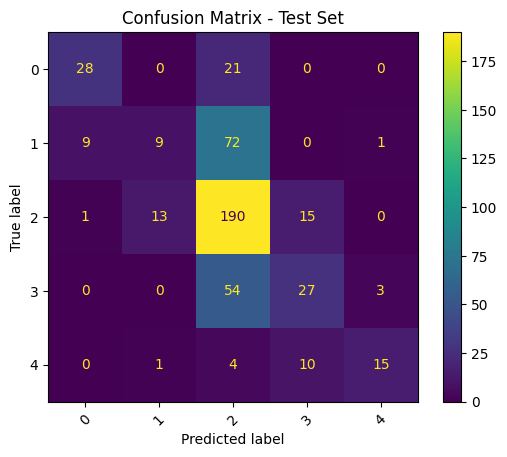

Classification Report (Test Set):

              precision    recall  f1-score   support

     Class 0       0.74      0.57      0.64        49
     Class 1       0.39      0.10      0.16        91
     Class 2       0.56      0.87      0.68       219
     Class 3       0.52      0.32      0.40        84
     Class 4       0.79      0.50      0.61        30

    accuracy                           0.57       473
   macro avg       0.60      0.47      0.50       473
weighted avg       0.55      0.57      0.52       473



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Step 1: Ottieni le previsioni del modello sul test set
y_test_pred_prob = model.predict(X_test)  # Probabilità delle classi
y_test_pred = np.argmax(y_test_pred_prob, axis=1)  # Classe predetta

# Step 2: Calcola l'AUC per ogni classe (se multi-classe)
try:
    y_test_one_hot = tf.keras.utils.to_categorical(y_test)  # Conversione a one-hot
    auc_test = roc_auc_score(y_test_one_hot, y_test_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC macro-averaged (Test Set): {auc_test:.4f}")
except ValueError as e:
    print(f"Impossibile calcolare AUC per il Test Set: {e}")

# Step 3: Calcola la confusion matrix per il test set
cm_test = confusion_matrix(y_test, y_test_pred)

# Step 4: Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Step 5: Calcola Precision, Recall, F1-score e Accuracy per classe sul test set
report_test = classification_report(y_test, y_test_pred, target_names=[f"Class {i}" for i in np.unique(y_test)])
print("Classification Report (Test Set):\n")
print(report_test)


**The model achieves moderate classification performance, but class prediction imbalance remains an issue. Specifically, it tends to overpredict the majority class, which negatively impacts the classification of classes 1 and 3, leading to a lower recall for these categories.**

## MONTE CARLO DROPOUT (to determine the confidence interval for our metrics)
### Applied on the best trained model for this task which achieved: 57% accuracy on the test set and 0.76 AUC

In [17]:
import tensorflow as tf

# Path to your model inside Kaggle dataset
model_path = "/kaggle/input/bestmodel/tensorflow2/default/1/model_Nodules_multiclass.h5"  # Adjust filename if needed

# Load the model
model = tf.keras.models.load_model(model_path)

model.trainable = False
model.get_layer("dropout3").trainable=True



In [15]:
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def compute_metric_ci_interval(metric):
    """
    Compute mean, standard deviation, and 95% confidence interval for a given metric.
    """
    mean_metric = np.mean(metric, axis=0)
    std_metric = np.std(metric, axis=0)
    ci_lower = mean_metric - 1.96 * std_metric
    ci_upper = mean_metric + 1.96 * std_metric
    
    return mean_metric, ci_lower, ci_upper, std_metric

def compute_metrics(probs, labels, n_classes):
    """
    Computes accuracy, F1-score, precision, recall, AUC, and class-wise confusion matrix metrics.
    Uses probability outputs instead of hard predictions for AUC calculation.
    """
    preds = np.argmax(probs, axis=1)  # Convert probabilities to class predictions
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')  # Macro for multiclass
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    
    # Compute One-vs-Rest AUC for each class
    labels_one_hot = keras.utils.to_categorical(labels, num_classes=n_classes)
    roc_auc = roc_auc_score(labels_one_hot, probs, average='macro', multi_class='ovr')

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    
    tpr = np.zeros(n_classes)
    fpr = np.zeros(n_classes)
    tnr = np.zeros(n_classes)
    fnr = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        tpr[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr[i] = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
        fnr[i] = fn / (fn + tp) if (fn + tp) > 0 else 0

    return accuracy, f1, precision, recall, roc_auc, tpr, fpr, tnr, fnr
    

def monte_carlo_simulation(model, X_test, y_test, n_classes=5, n_simulations=100):
    """
    Performs Monte Carlo Dropout-based uncertainty estimation for multiclass classification.
    """
    
    test_probs = []
    test_preds = []

    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    test_auc = []
    test_fpr = []
    test_tpr = []
    test_tnr = []
    test_fnr = []
    
    for i in range(n_simulations):
        logits = model.predict(X_test)  # Ensure correct scaling
        probs = keras.activations.softmax(logits).numpy()  # Apply softmax for multi-class
        
        test_probs.append(probs)  # Save probabilities
        test_preds.append(np.argmax(probs, axis=1))  # Save predictions
        
        accuracy, f1, precision, recall, auc_score, tpr, fpr, tnr, fnr = compute_metrics(probs, y_test, n_classes)
        
        test_acc.append(accuracy)
        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)
        test_auc.append(auc_score)
        test_fpr.append(fpr)
        test_tpr.append(tpr)
        test_tnr.append(tnr)
        test_fnr.append(fnr)
    
    return test_probs, test_preds, (test_acc, test_f1, test_precision, test_recall, test_auc, test_fpr, test_tpr, test_tnr, test_fnr)


In [16]:
import tensorflow as tf


class MCModel(tf.keras.Model):
    def call(self, inputs, training=True):  # Force training mode
        return super().call(inputs, training=True)

# Convert your existing model into an MC model
mc_model2 = MCModel(inputs=model.input, outputs=model.output)

# Run Monte Carlo Dropout Testing
test_probs, test_preds, test_metrics = monte_carlo_simulation(mc_model2, X_test, y_test, n_classes=5, n_simulations=50)
# Compute confidence intervals
acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[0])
print(f"Accuracy: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[1])
print(f"F1: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[2])
print(f"precision: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[3])
print(f"recall: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[4])
print(f"AUC: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

I0000 00:00:1738775014.704860      95 service.cc:145] XLA service 0x788ef4089d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738775014.704924      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

I0000 00:00:1738775033.345472      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1